## KC Metro Data Exploration

Bootstrap the CSVs into dataframes.

In [25]:
## Get a dataframe going.

import os
import pandas as pd

# REF: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#copy-on-write-optimizations
# Used based on warning when attempting to update a subset of a dataframe downstream.
pd.set_option('mode.copy_on_write', True)
pd.options.mode.copy_on_write = True

AGENCY_DIR = 'kc_metro'

data = {
    "calendar": {
        "csv": "calendar.txt",
        "df": None
    },
    "routes": {
        "csv": "routes.txt",
        "df": None
    },
    "stops": {
        "csv": "stops.txt",
        "df": None
    },
    "stop_times": {
        "csv": "stop_times.txt",
        "df": None
    },
    "trips": {
        "csv": "trips.txt",
        "df": None
    },
}

for header, vals in data.items():
    data_dir = os.path.join(os.getcwd(), os.pardir, os.pardir, 'data')
    data_csv =  os.path.join(data_dir, AGENCY_DIR, vals['csv'])
    data_df = pd.read_csv(data_csv)
    data[header]['df'] = data_df


#### Try to find all stops for a given route (from `routes.txt`)

In [26]:
ROUTES = {
    48: 100228,
    8: 100275,
    153: 100048,
}

ROUTE_ID = ROUTES[153]

# Get some sample `trip_id` values for Route 8
# From `trips.txt`
trips_df = data['trips']['df']
trips_filtered_by_route = trips_df[trips_df['route_id'] == ROUTE_ID]['trip_id']
trips_filtered_by_route.head()


12523    572987776
12524    572987826
12525    572987836
12526    572987856
12527    572987866
Name: trip_id, dtype: int64

In [27]:
FIRST_TRIP_ID = trips_filtered_by_route.head(1).values[0]

# Filter `stop_times.txt` to get stop ids
stop_times_df = data['stop_times']['df']
stop_ids = stop_times_df[stop_times_df['trip_id'] == FIRST_TRIP_ID]['stop_id']

# Total number of stop counts
stop_ids.count()

np.int64(35)

In [28]:
# Join previously filtered stop_ids to stops.txt
# giving us the stop geometries

stops_df = data['stops']['df']

stops_filtered_by_route = pd.merge(stop_ids, stops_df)

stops_filtered_by_route.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,8402,8402,Mount Baker Transit Center - Bay 2,NaN,47.577591,-122.297127,1,NaN,0,NaN,America/Los_Angeles,1
1,8672,8672,Martin L King Jr Way S & S Bayview St,NaN,47.581486,-122.297020,1,NaN,0,NaN,America/Los_Angeles,1
2,36752,36752,Martin L King Jr Way S & S Walker St,NaN,47.583851,-122.298042,1,NaN,0,NaN,America/Los_Angeles,1
3,12497,12497,Martin L King Jr Way S & S Massachusetts St,NaN,47.588676,-122.297852,1,NaN,0,NaN,America/Los_Angeles,1
4,43765,43765,Martin L King Jr Way S & S Irving St,NaN,47.590630,-122.297348,1,NaN,0,NaN,America/Los_Angeles,1


In [29]:
## Make a map

import folium

m = folium.Map(location=[47.617, -122.34], zoom_start=15)

## `Polyline()` Expects a list of coordinate tuples.
coord_data = list(zip(stops_filtered_by_route['stop_lat'], stops_filtered_by_route['stop_lon']))

## Get the route name

route_df = data['routes']['df']
route_num = route_df[route_df['route_id'] == ROUTE_ID]['route_short_name'].values[0]
route_name = route_df[route_df['route_id'] == ROUTE_ID]['route_desc'].values[0]
route_name_pretty = " | ".join([route_num, route_name])

folium.PolyLine(coord_data, tooltip=route_name_pretty).add_to(m)

## Display the map
m

## Side Journey: Understand if a trip is weekday/weekend etc via the `service_id` attribute.

- `trips.txt` contains a `service_id` attribute which is used to determine
the days of service for a given trip (e.g weekday, weekend, special).

- I need to group trips by a particular service to avoid double counting.

In [30]:
service_ids = trips_df[trips_df['route_id'] == ROUTE_ID]['service_id']
service_ids.value_counts()

service_id
18192     145
123724    145
3105      127
27082     127
4282       99
26266      99
Name: count, dtype: int64

In [31]:
cal_df = data['calendar']['df']

cal_df[cal_df['service_id'].isin(service_ids.unique())]

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
6,123724,1,1,0,0,1,0,0,20240916,20250328
28,27082,0,0,0,0,0,1,0,20240914,20250322
29,26266,0,0,0,0,0,0,1,20240915,20250323
36,18192,0,1,1,1,1,0,0,20240819,20240913
50,4282,0,0,0,0,0,0,1,20240825,20240908
53,3105,0,0,0,0,0,1,0,20240824,20240907


## Try to generate a visualization showing the frequency of trips by hour for a given route

In [32]:
## filter stop_times.txt by trip_id where stop_sequence is 1
trips_and_stop_times = pd.merge(trips_filtered_by_route, stop_times_df, on='trip_id')

trips_first_stop_only = trips_and_stop_times[trips_and_stop_times['stop_sequence'] == 1]

## Note: `arrival_time` represents midnight values as 24:00:00 versus 00:00:00.
## Need to convert arrival time hour values of `24` to `00`
trips_first_stop_only['arrival_time'] = trips_first_stop_only['arrival_time'].str.replace('^24', '00', regex=True)
trips_first_stop_only['arrival_time'] = trips_first_stop_only['arrival_time'].str.replace('^25', '01', regex=True)
trips_first_stop_only['arrival_time'] = trips_first_stop_only['arrival_time'].str.replace('^26', '02', regex=True)
trips_first_stop_only['arrival_time'] = trips_first_stop_only['arrival_time'].str.replace('^27', '03', regex=True)
trips_first_stop_only['arrival_time'] = trips_first_stop_only['arrival_time'].str.replace('^28', '04', regex=True)
trips_first_stop_only['arrival_time'].sort_values()
## Update `arrival_time` to be a datetime object
trips_first_stop_only['arrival_time'] = pd.to_datetime(trips_first_stop_only['arrival_time'], format='%H:%M:%S')

trips_first_stop_only.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,572987776,1900-01-01 00:26:00,24:26:00,8402,1,NaN,0,0,0.0,1
35,572987826,1900-01-01 06:21:00,06:21:00,8402,1,NaN,0,0,0.0,1
70,572987836,1900-01-01 06:51:00,06:51:00,8402,1,NaN,0,0,0.0,1
105,572987856,1900-01-01 07:51:00,07:51:00,8402,1,NaN,0,0,0.0,1
140,572987866,1900-01-01 08:06:00,08:06:00,8402,1,NaN,0,0,0.0,1


In [33]:
## Rejoin with trips.txt to get the service_id

trips_with_service_id = pd.merge(trips_first_stop_only, trips_df, on='trip_id')
trips_with_service_id

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,service_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id,wheelchair_accessible,bikes_allowed
0,572987776,1900-01-01 00:26:00,24:26:00,8402,1,NaN,0,0,0.0,1,...,3105,Seattle Center,LOCAL,0,7331487,31008004,0,101,1,1
1,572987826,1900-01-01 06:21:00,06:21:00,8402,1,NaN,0,0,0.0,1,...,3105,Seattle Center,LOCAL,0,7331437,31008004,0,101,1,1
2,572987836,1900-01-01 06:51:00,06:51:00,8402,1,NaN,0,0,0.0,1,...,3105,Seattle Center,LOCAL,0,7331420,31008004,0,101,1,1
3,572987856,1900-01-01 07:51:00,07:51:00,8402,1,NaN,0,0,0.0,1,...,3105,Seattle Center,LOCAL,0,7331421,31008004,0,101,1,1
4,572987866,1900-01-01 08:06:00,08:06:00,8402,1,NaN,0,0,0.0,1,...,3105,Seattle Center,LOCAL,0,7331422,31008004,0,101,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,694016317,1900-01-01 23:01:00,23:01:00,8402,1,NaN,0,0,0.0,1,...,27082,Seattle Center,LOCAL,0,7333485,31008006,0,101,1,1
738,694016327,1900-01-01 23:31:00,23:31:00,8402,1,NaN,0,0,0.0,1,...,27082,Seattle Center,LOCAL,0,7333486,31008006,0,101,1,1
739,694016337,1900-01-01 00:01:00,24:01:00,8402,1,NaN,0,0,0.0,1,...,27082,Seattle Center,LOCAL,0,7333498,31008006,0,101,1,1
740,694017697,1900-01-01 20:00:00,20:00:00,2672,1,NaN,0,0,0.0,1,...,27082,Mount Baker Transit Center,LOCAL,1,7333485,40008005,0,101,1,1


In [34]:
trips_with_service_id['arrival_time'].sort_values()

251   1900-01-01 00:00:00
441   1900-01-01 00:00:00
129   1900-01-01 00:00:00
739   1900-01-01 00:01:00
559   1900-01-01 00:01:00
              ...        
291   1900-01-01 23:41:00
601   1900-01-01 23:43:00
118   1900-01-01 23:53:00
514   1900-01-01 23:54:00
61    1900-01-01 23:56:00
Name: arrival_time, Length: 742, dtype: datetime64[ns]

In [35]:
## Get the number of trips by hour
trips_per_hour = trips_with_service_id.groupby([trips_with_service_id['arrival_time'].dt.hour, trips_with_service_id['service_id'], trips_with_service_id['direction_id']]).size()
trips_per_hour

arrival_time  service_id  direction_id
0             3105        0               1
                          1               1
              4282        0               1
                          1               2
              18192       0               2
                                         ..
23            26266       1               2
              27082       0               2
                          1               2
              123724      0               2
                          1               2
Length: 236, dtype: int64

<Axes: xlabel='arrival_time,service_id,direction_id'>

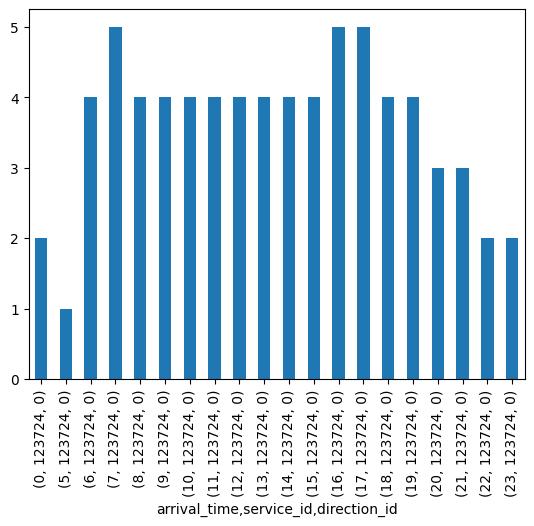

In [36]:
import matplotlib.pyplot as plt

SERVICE_ID_MTF = 123724
DIRECTION_ID_OUTBOUND = 0
DIRECTION_ID_INBOUND = 1

trips_per_hour_MTF = trips_per_hour[
    (trips_per_hour.index.get_level_values('service_id') == SERVICE_ID_MTF) &
    (trips_per_hour.index.get_level_values('direction_id') == DIRECTION_ID_OUTBOUND)
    ]

trips_per_hour_MTF.plot(kind='bar')

<Axes: xlabel='arrival_time,service_id,direction_id'>

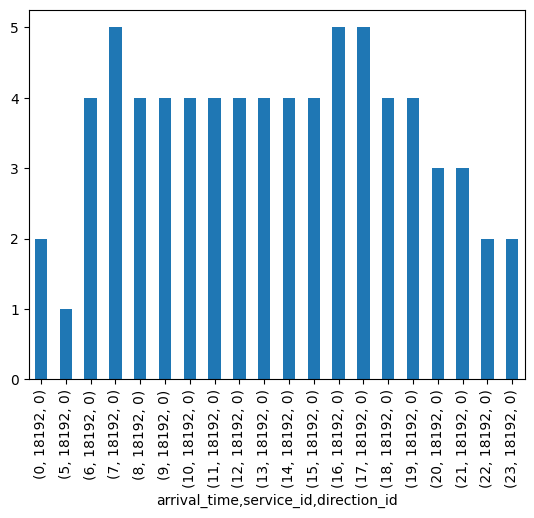

In [37]:
SERVICE_ID_TWRF = 18192

trips_per_hour_TWRF = trips_per_hour[
    (trips_per_hour.index.get_level_values('service_id') == SERVICE_ID_TWRF) &
    (trips_per_hour.index.get_level_values('direction_id') == DIRECTION_ID_OUTBOUND)
    ]
trips_per_hour_TWRF.plot(kind='bar')

<Axes: xlabel='arrival_time,service_id,direction_id'>

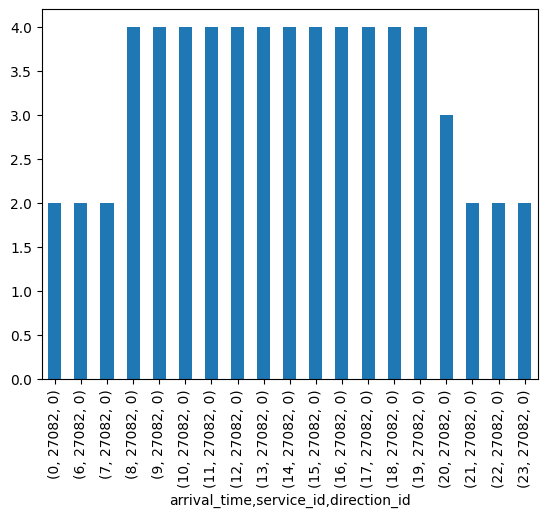

In [38]:
SERVICE_ID_SAT = 27082

trips_per_hour_SAT = trips_per_hour[
    (trips_per_hour.index.get_level_values('service_id') == SERVICE_ID_SAT) &
    (trips_per_hour.index.get_level_values('direction_id') == DIRECTION_ID_OUTBOUND)
    ]
trips_per_hour_SAT.plot(kind='bar')